## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-09-11 23:11:34.937811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-11 23:11:34.937848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Controllable hyperparameters

In [2]:
# We can use these to slice a pandas datetime index
warmup_start = '20210601'
warmup_end = '20210630'
train_start = '20210701'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

# How long can a person take to progress?
transition_window = 30

# CovidEstim Hyper param
T_serial = 5.8

# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94

# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G
alpha_bar = 1
beta_bar = 1

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so
# Here we use a diffuse normal distribution with a mean at 10 days for all compartments
# but we could specify a different prior for each M, X, G
lambda_bar = 10
sigma_bar = 5

# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days
# Here we use a diffuse normal distribution with a mean at 10 for all compartments
# but we could specify a different prior for each M, X, G
nu_bar = 10
tau_bar = 5

# Learning rate
learning_rate = 1e-1


## Model size globals


In [3]:
# Globals are ugly
# could create an enum or make them properties of a model class or something
COMPARTMENTS = 4
ASYMP = 0
MILD = 1
EXTREME = 2
GENERAL_WARD = 3

## Create Warmup Data

In [4]:
# Local data folder containing downloads from OWID, HHS, and CovidEstim
# Filenames are the date the data was accessed
data_dir = '/mnt/c/Users/kheut/data/covid/'

covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

covid_estim_path = os.path.join(data_dir,'covidestim', covid_estim_date+'.csv')
hhs_path = os.path.join(data_dir,'hhs', hhs_date+'.csv')
owid_path = os.path.join(data_dir,'owid', owid_date+'_vaccinations.csv')




### Read CovidEstim


In [5]:
# Read covid estim
covid_estim = pd.read_csv(covid_estim_path)
# filter to state
covid_estim = covid_estim[covid_estim['state']==state]
# Make sure date is unique
assert len(covid_estim)==len(covid_estim.date.unique())

# create datetime index
covid_estim.loc[:, 'date'] = pd.to_datetime(covid_estim['date'])
covid_estim = covid_estim.set_index('date').sort_index()
# Rename to match our compartments
covid_estim = covid_estim.rename(columns={'infections':'infected',
                                          'severe':'extreme',
                                          'symptomatic':'mild'
                                          })
# Create asymptomatic by subtracting mild and extreme from all infections
covid_estim.loc[:,'asymp'] = covid_estim['infected'] -\
    covid_estim['mild'] - covid_estim['extreme']


### Read HHS for outcome variable

In [6]:
hhs = pd.read_csv(hhs_path)
hhs = hhs[hhs['state']==state_abbrev]
assert len(hhs) == len(hhs.date.unique())

# we have previous day admissions, so add 1 to date
hhs.loc[:, 'date'] = pd.to_datetime(hhs['date']) + pd.DateOffset(days=1)
hhs = hhs.set_index('date').sort_index()
hhs = hhs.rename(columns={'previous_day_admission_adult_covid_confirmed':'general_ward'})


### Read Our World In Data for a clean CDC state-level vaccine timeseries

In [7]:
owid = pd.read_csv(owid_path)
owid = owid[owid['location']==state]
owid.loc[:, 'date'] = pd.to_datetime(owid['date'])
owid = owid.set_index('date').sort_index()
# There are NaN's in the vaccine timeseries, so linearly interpolate
owid.loc[:, 'people_fully_vaccinated_per_hundred'] = owid[['people_fully_vaccinated_per_hundred']].interpolate(method='linear')
owid['vax_pct'] = owid[['people_fully_vaccinated_per_hundred']]*0.01

### Merge all warmup data together on the common date index

In [8]:
df = pd.merge(hhs[['general_ward']],
              covid_estim[['infected','asymp','extreme','mild', 'Rt']],
              how='outer',
              left_index=True, right_index=True).merge(owid[['vax_pct']], how='outer', left_index=True, right_index=True)


### Create arrays of warmup data

In [9]:
warmup_infected = {}
warmup_asymp = {}
warmup_mild = {}
warmup_extreme = {}

not_vaxxed=0
vaxxed=1

# vaccines protect from infection/asymp/mild/extreme/general
# multiply population vaccinated by (1-protection %) to get vaccinated
warmup_asymp[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[warmup_start:warmup_end, 'asymp']).values
warmup_asymp[not_vaxxed] = df.loc[warmup_start:warmup_end, 'asymp'].values - warmup_asymp[vaxxed]

warmup_mild[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[warmup_start:warmup_end, 'mild']).values
warmup_mild[not_vaxxed] = df.loc[warmup_start:warmup_end, 'mild'].values - warmup_mild[vaxxed]

warmup_extreme[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[warmup_start:warmup_end, 'extreme']).values
warmup_extreme[not_vaxxed] = df.loc[warmup_start:warmup_end, 'extreme'].values - warmup_extreme[vaxxed]

warmup_infected[vaxxed] = warmup_asymp[vaxxed] + warmup_mild[vaxxed] + warmup_extreme[vaxxed]
warmup_infected[not_vaxxed] = warmup_asymp[not_vaxxed] + warmup_mild[not_vaxxed] + warmup_extreme[not_vaxxed]

training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

testing_rt = df.loc[test_start:test_end,'Rt'].values
testing_general_ward = df.loc[test_start:test_end,'general_ward'].values


test_warmup_infected = {}
test_warmup_asymp = {}
test_warmup_mild = {}
test_warmup_extreme = {}

# vaccines protect from infection/asymp/mild/extreme/general
# multiply population vaccinated by (1-protection %) to get vaccinated
test_warmup_asymp[vaxxed] = (df.loc[train_start:train_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[train_start:train_end, 'asymp']).values
test_warmup_asymp[not_vaxxed] = df.loc[train_start:train_end, 'asymp'].values - test_warmup_asymp[vaxxed]

test_warmup_mild[vaxxed] = (df.loc[train_start:train_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[train_start:train_end, 'mild']).values
test_warmup_mild[not_vaxxed] = df.loc[train_start:train_end, 'mild'].values - test_warmup_mild[vaxxed]

test_warmup_extreme[vaxxed] = (df.loc[train_start:train_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[train_start:train_end, 'extreme']).values
test_warmup_extreme[not_vaxxed] = df.loc[train_start:train_end, 'extreme'].values - test_warmup_extreme[vaxxed]

test_warmup_infected[vaxxed] = test_warmup_asymp[vaxxed] + test_warmup_mild[vaxxed] + test_warmup_extreme[vaxxed]
test_warmup_infected[not_vaxxed] = test_warmup_asymp[not_vaxxed] + test_warmup_mild[not_vaxxed] + test_warmup_extreme[not_vaxxed]

## Define The Model

In [17]:
class CovidModel(tf.keras.Model):
    
    def __init__(self, transition_window, T_serial,
                 alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G,
                 compartments=COMPARTMENTS):
        """Covid Model 1.5
        
        Args:
            transition_window (int): J in our notation, the number of days to consider a 
                possible transition to a more severe state
            T_serial (float): CovidEstim infection hyperparameter
            alpha_bar_M (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            beta_bar_M (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            alpha_bar_X (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            beta_bar_X (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            alpha_bar_G (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an individual with eXtreme symptoms progresses to the hospital
            beta_bar_G (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            lambda_bar_M (float): The mean of a strictly-positive Normal distribution prior over lambda_M, the rate
                of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            sigma_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_M,
                the rate of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            lambda_bar_X (float): The mean of a strictly-positive Normal distribution prior over lambda_X, the rate
                of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            sigma_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_X,
                the rate of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            lambda_bar_G (float): The mean of a strictly-positive Normal distribution prior over lambda_G, the rate
                of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General ward
            sigma_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_G,
                the rate of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General Ward
            nu_bar_M (float): The mean of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_X (float): The mean of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_G (float): The mean of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
        """
        super(CovidModel, self).__init__()
        
        self.transition_window = transition_window
        self.T_serial = T_serial
        self.compartments = compartments
        
        # create dictionaries to store model parameters / prior distributions
        self._initialize_parameters(lambda_bar_M, lambda_bar_X, lambda_bar_G,
                                    nu_bar_M, nu_bar_X, nu_bar_G)
        self._initialize_priors(alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                                lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                                nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G)
        
    
    def call(self, inputs, debug_disable_prior=True):
        """Run covid model 1.5
        
        Args:
            inputs (tuple(tf.Tensor)): A tuple of all input tensors we need. It should be, in order:
                (rt,
                 warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
                 warmup_mild_not_vaxxed, warmup_mild_vaxxed,
                 warmup_extreme_not_vaxxed, warmup_extreme_vaxxed)
                rt should be size (1, days_to_forecast), while
                warmup data should be size (1, days_of_warmup)
            debug_disable_prior (bool): If True, will disable adding the prior to the loss. Used to debug gradients
        Returns:
            tf.Tensor: A tensor size (1, days_to_forecast) of incident hospital admissions
        """
        
        # Tensorflow models are typically a single tensor or a tuple of multiple tensors
        # This function accepts all the input tensors we need (r_t, warmup for AMX, both vaxxed and non-vaxxed)
        # and returns r_t, along with dictionaries keyed on vaccination status for easier use.
        r_t, warmup_asymp, warmup_mild, warmup_extreme = self._parse_inputs(inputs)
        
        # TODO: make dynamic - passing constants into tensorflow is weird
        warmup_days_val = 30
        forecast_days_val = 31
        
        # It's a little weird to iteratively write to tensors one day at a time
        # To do this, we'll use TensorArray's, arrays of tensors where each element is a tensor representing
        # one compartment/vaccine status/ day
        # This helper function creates a nested dictionary keyed on:
        #  compartment-> 
        #      vaccinestatus->
        #           TensorArray with one tensor per day from:
        #               warmup_start to forecast_end for any quantities with warmup data
        #               forecast_start to forecast_end for the outcome, which does not have warmup data
        forecasted_fluxes = self._initialize_flux_arrays(warmup_asymp, warmup_mild, warmup_extreme,
                                                         warmup_days_val, forecast_days_val)
        
        # Our model parameters have several constraints (being between 0-1, being positive)
        # So we need to transform them from the unconstrained space they are modeled in
        # This call transforms them and saves them properties of this model object (self):
        #     epsilon, a scalar with value between 0-1
        #     delta, a dictionary of scalars keyed on vaccination status with values between 0-1
        #     rho_M, rho_X, rho_G: dictionaries of tensors keyed on vaccination status with values between 0-1
        #     lambda_M,  lambda_X, lambda_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     nu_M, nu_X, nu_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     poisson_M, poisson_X, poisson_G: dictionaries of probability distribution objects keyed on vaccine status
        #     pi_M, pi_X, pi_G: dictionaries of tensor arrays with 1 element for each of the past J days
        #     previously_asymptomatic, previously_mild, previously_extreme: dictionaries of tensor arrays with 1 element for each of the past J days
        
        self._constrain_parameters()
        
        if not debug_disable_prior:
            self._add_prior_loss()

        # forecast from the end of warmup to the end of forecasting
        for day in range(warmup_days_val, forecast_days_val+warmup_days_val):
            
            # Start with asymptomatic
            asymp_t_1_no_vax = forecasted_fluxes[ASYMP][0].read(day-1)
            asymp_t_1_vax = forecasted_fluxes[ASYMP][1].read(day-1)
            combined_asymp_covariate = asymp_t_1_no_vax + self.epsilon * asymp_t_1_vax
            
            

            for vax_status in range(2):
                
                forecasted_fluxes[ASYMP][vax_status]  = forecasted_fluxes[ASYMP][vax_status].write(day,
                    tf.squeeze(combined_asymp_covariate * self.delta[vax_status] * r_t[day-warmup_days_val]* (1/self.T_serial))
                )

                # get last J days of AMX
                for j in range(self.transition_window):
                    self.previously_asymptomatic[vax_status] = self.previously_asymptomatic[vax_status].write(j,
                        forecasted_fluxes[ASYMP][vax_status].read(day-(j+1)))

                    self.previously_mild[vax_status] = self.previously_mild[vax_status].write(j,
                        forecasted_fluxes[MILD][vax_status].read(day-(j+1)))
                    self.previously_extreme[vax_status] = self.previously_extreme[vax_status].write(j,
                        forecasted_fluxes[EXTREME][vax_status].read(day-(j+1)))                    
                
                previously_asymptomatic_tensor = self.previously_asymptomatic[vax_status].stack()
                previously_mild_tensor = self.previously_mild[vax_status].stack()
                previously_extreme_tensor = self.previously_extreme[vax_status].stack()
               
                forecasted_fluxes[MILD][vax_status]  = forecasted_fluxes[MILD][vax_status].write(day,
                    tf.reduce_sum(previously_asymptomatic_tensor * self.rho_M[vax_status] * self.pi_M[vax_status], axis=0)
                )
                     
                forecasted_fluxes[EXTREME][vax_status]  = forecasted_fluxes[EXTREME][vax_status].write(day,
                    tf.reduce_sum(previously_mild_tensor * self.rho_X[vax_status] * self.pi_X[vax_status], axis=0)
                )
                    
                forecasted_fluxes[GENERAL_WARD][vax_status]  = forecasted_fluxes[GENERAL_WARD][vax_status].write(day-warmup_days_val,
                    tf.reduce_sum(previously_extreme_tensor * self.rho_G[vax_status] * self.pi_G[vax_status], axis=0)
                )

                
        # Re-combine vaccinated and unvaxxed for our output
        result = forecasted_fluxes[GENERAL_WARD][0].stack()+ forecasted_fluxes[GENERAL_WARD][1].stack()
        
        # Tensorflow thinks we didn't use every array, so we gotta mark them as used
        # TODO: did i screw up?
        self._mark_arrays_used(forecasted_fluxes)
            
        return result
    
    def _initialize_parameters(self, lambda_bar_M, lambda_bar_X, lambda_bar_G,
                               nu_bar_M, nu_bar_X, nu_bar_G):
        """Helper function to hide the book-keeping behind initializing model parameters
        
        TODO: Replace with better initializations
        """
        
        self.model_params = {}
        
        for compartment in range(self.compartments):
            self.model_params[compartment] = {}
            for vax_status in [0, 1]:
                self.model_params[compartment][vax_status] = {}
        
        self.unconstrained_eps = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal", trainable=True, name=f'eps')
        self.unconstrained_delta = {}
        
        # initialize model parameters
        for vax_status in [0, 1]:
            
            self.unconstrained_delta[vax_status] = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal", trainable=True, name=f'A_delta_{vax_status}')
            
            self.model_params[MILD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'M_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_M], name=f'M_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_M], name=f'M_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'X_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_X], name=f'X_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_X], name=f'X_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'G_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_G], name=f'G_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_G], name=f'G_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))


        return
    
    def _initialize_priors(self, alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                           lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                           nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G):
        """Helper function to hide the book-keeping behind initializing model priors"""
        
        self.prior_distros = {}
        for compartment in range(self.compartments):
            self.prior_distros[compartment] = {}
            for vax_status in [0, 1]:
                self.prior_distros[compartment][vax_status] = {}
                
        # create prior distributions
        for vax_status in [0,1]:
            self.prior_distros[MILD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_M, beta_bar_M)
            self.prior_distros[EXTREME][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_X, beta_bar_X)
            self.prior_distros[GENERAL_WARD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_G, beta_bar_G)
            
            # We want these to be positive so we use a truncated normal with range 0-100
            self.prior_distros[MILD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_M, sigma_bar_M, 0, 100)
            self.prior_distros[EXTREME][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_X, sigma_bar_X, 0, 100)
            self.prior_distros[GENERAL_WARD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_G, sigma_bar_G, 0, 100)
            
            self.prior_distros[MILD][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_M, tau_bar_M, 0, 100)
            self.prior_distros[EXTREME][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_X, tau_bar_X, 0, 100)
            self.prior_distros[GENERAL_WARD][vax_status]['nu'] = tfp.distributions.Normal(nu_bar_G, tau_bar_G, 0, 100)
        
        return
    
    def _parse_inputs(self, inputs):
        """Helper function to hide the logic in parsing the big mess of input tensors we get"""
        (r_t,
         warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
         warmup_mild_not_vaxxed, warmup_mild_vaxxed,
         warmup_extreme_not_vaxxed, warmup_extreme_vaxxed) = inputs
        
        r_t = tf.squeeze(r_t)
        
        warmup_asymp = {}
        warmup_asymp[0] = tf.squeeze(warmup_asymp_not_vaxxed)
        warmup_asymp[1] = tf.squeeze(warmup_asymp_vaxxed)
        
        warmup_mild = {}
        warmup_mild[0] = tf.squeeze(warmup_mild_not_vaxxed)
        warmup_mild[1] = tf.squeeze(warmup_mild_vaxxed)
        
        warmup_extreme = {}
        warmup_extreme[0] = tf.squeeze(warmup_extreme_not_vaxxed)
        warmup_extreme[1] = tf.squeeze(warmup_extreme_vaxxed)
        
        return r_t, warmup_asymp, warmup_mild, warmup_extreme
        
    def _initialize_flux_arrays(self, warmup_asymp, warmup_mild, warmup_extreme,
                                warmup_days, forecast_days):
        """Helper function to hide the plumbing in creating TensorArrays for every output
        
        Args:
            warmup_days (int): Number of days of warmup data
            forecast_days (int): Number of days to forecast
        Returns
            dict{int:dict{int:TensorArray}}: Nested dictionary keyed on compartment->vaccine status,
                containing a TensorArray for every quantity
        """
        
        forecasted_fluxes = {}
        
        for compartment in range(self.compartments):
            forecasted_fluxes[compartment] = {}
            
            # No need to store warmup data for the outcome
            if compartment == GENERAL_WARD:
                array_size = forecast_days
            else:
                array_size = warmup_days + forecast_days
            
            for vax_status in range(2):
                forecasted_fluxes[compartment][vax_status] = tf.TensorArray(tf.float32, size=array_size,
                                                                            clear_after_read=False,
                                                                            name=f'{compartment}_{vax_status}')
                
        # Write the warmup data to the array so we don't have to look in two places:
        for day in range(warmup_days):
            for vax_status in range(2):
                forecasted_fluxes[ASYMP][vax_status] = \
                    forecasted_fluxes[ASYMP][vax_status].write(day,
                                                                  warmup_asymp[vax_status][day])
                forecasted_fluxes[MILD][vax_status] = \
                    forecasted_fluxes[MILD][vax_status].write(day,
                                                                  warmup_mild[vax_status][day])
                forecasted_fluxes[EXTREME][vax_status] = \
                    forecasted_fluxes[EXTREME][vax_status].write(day,
                                                                  warmup_extreme[vax_status][day])

        return forecasted_fluxes
    
    def _constrain_parameters(self):
        """Helper function to hide the plumbing of creating the constrained parameters and other model TensorArrays"""
        
        # Must be 0-1
        self.epsilon = tf.math.sigmoid(self.unconstrained_eps)
        
        self.delta = {}
        for vax_status in range(2):
            self.delta[vax_status] = tf.squeeze(tf.math.sigmoid(self.unconstrained_delta[vax_status]))
        
        # Initialize dictionaries keyed on vax status
        self.rho_M = {}
        self.rho_X = {}
        self.rho_G = {}
        self.lambda_M = {}
        self.lambda_X = {}
        self.lambda_G = {}
        self.nu_M = {}
        self.nu_X = {}
        self.nu_G = {}
        self.poisson_M = {}
        self.poisson_X = {}
        self.poisson_G = {}
        self.pi_M = {}
        self.pi_X = {}
        self.pi_G = {}

        self.previously_asymptomatic = {}
        self.previously_mild = {}
        self.previously_extreme = {}

        for vax_status in range(2):

            # Rho must be 0-1, so use sigmoid
            # lambda and nu must be positive, so use softplus
            self.rho_M[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[MILD][vax_status]['unconstrained_rho']))
            self.lambda_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_lambda']))
            self.nu_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_nu']))

            self.rho_X[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[EXTREME][vax_status]['unconstrained_rho']))
            self.lambda_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_lambda']))
            self.nu_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_nu']))

            self.rho_G[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho']))
            self.lambda_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda']))
            self.nu_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu']))

            # Create the distributions for each compartment
            self.poisson_M[vax_status] = tfp.distributions.Poisson(rate=self.lambda_M[vax_status])
            self.poisson_X[vax_status] = tfp.distributions.Poisson(rate=self.lambda_X[vax_status])
            self.poisson_G[vax_status] = tfp.distributions.Poisson(rate=self.lambda_G[vax_status])

            # pi is fixed while we forecast so we can create that now
            self.pi_M[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_M')
            self.pi_X[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_X')
            self.pi_G[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_G')
            for j in range(self.transition_window):
                self.pi_M[vax_status] = self.pi_M[vax_status].write(j, self.poisson_M[vax_status].log_prob(j+1)/self.nu_M[vax_status])
                self.pi_X[vax_status] = self.pi_X[vax_status].write(j, self.poisson_X[vax_status].log_prob(j+1)/self.nu_X[vax_status])
                self.pi_G[vax_status] = self.pi_G[vax_status].write(j, self.poisson_G[vax_status].log_prob(j+1)/self.nu_G[vax_status])

            # stacking the TensorArray makes it a tensor again
            self.pi_M[vax_status] = tf.transpose(self.pi_M[vax_status].stack())
            # Softmax so it sums to 1
            self.pi_M[vax_status] = tf.nn.softmax(self.pi_M[vax_status])

            self.pi_X[vax_status] = tf.transpose(self.pi_X[vax_status].stack())
            self.pi_X[vax_status] = tf.nn.softmax(self.pi_X[vax_status])
            self.pi_G[vax_status] = tf.transpose(self.pi_G[vax_status].stack())
            self.pi_G[vax_status] = tf.nn.softmax(self.pi_G[vax_status])

            # Initialize tensor arrays for storing these values
            self.previously_asymptomatic[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_asymp')
            self.previously_mild[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name=f'prev_mild')
            self.previously_extreme[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_extreme')

    def _add_prior_loss(self):
        """Helper function for adding loss from model prior"""
        
        for vax_status in range(2):
            # Add losses from param priors
            # Make everything negative because we're minimizing
            self.add_loss(-self.prior_distros[MILD][vax_status]['rho'].log_prob(self.rho_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['rho'].log_prob(self.rho_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['rho'].log_prob(self.rho_G[vax_status]))

            self.add_loss(-self.prior_distros[MILD][vax_status]['lambda'].log_prob(self.lambda_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['lambda'].log_prob(self.lambda_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['lambda'].log_prob(self.lambda_G[vax_status]))
            
            self.add_loss(-self.prior_distros[MILD][vax_status]['nu'].log_prob(self.nu_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['nu'].log_prob(self.nu_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['nu'].log_prob(self.nu_G[vax_status]))
            
    def _mark_arrays_used(self, forecasted_fluxes):
        """Helper function that supresses noisy error about not using all arrays"""
        for vax_status in range(2):
            forecasted_fluxes[ASYMP][vax_status].mark_used()
            forecasted_fluxes[MILD][vax_status].mark_used()
            forecasted_fluxes[EXTREME][vax_status].mark_used()
            forecasted_fluxes[GENERAL_WARD][vax_status].mark_used()
            self.previously_asymptomatic[vax_status].mark_used()
            self.previously_mild[vax_status].mark_used()
            self.previously_extreme[vax_status].mark_used()
            
        return



In [18]:
model = CovidModel(transition_window, T_serial,
                 alpha_bar, beta_bar, alpha_bar, beta_bar, alpha_bar, beta_bar,
                 lambda_bar, sigma_bar, lambda_bar, sigma_bar, lambda_bar, sigma_bar,
                 nu_bar, tau_bar, nu_bar, tau_bar, nu_bar, tau_bar)

In [19]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

# Custom LogPoisson Probability Loss function
def calc_poisson(inputs):
    true_rate, predicted_rate = inputs
    poisson = tfp.distributions.Poisson(rate=true_rate)
    return poisson.log_prob(predicted_rate)

class LogPoissonProb(tf.keras.losses.Loss):
    


    def call(self, y_true, y_pred):
        log_probs = tf.map_fn(calc_poisson, (tf.squeeze(y_true), y_pred), fn_output_signature=tf.float32)
        # return negative log likielihood
        return -tf.reduce_sum(log_probs)
    
loss = LogPoissonProb()

class VarLogCallback(tf.keras.callbacks.Callback):
    """Logs all our model parameters"""

    def __init__(self, every_nth_epoch=1):
        self.every_nth_epoch = every_nth_epoch

    def on_epoch_end(self, epoch, logs):

        if epoch % self.every_nth_epoch != 0:
            return

        for vax_status in [0, 1]:
            tf.summary.scalar(f'rho_M_{vax_status}',data=tf.squeeze(self.model.rho_M[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_X_{vax_status}',data=tf.squeeze(self.model.rho_X[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_G_{vax_status}',data=tf.squeeze(self.model.rho_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'lambda_M_{vax_status}',data=tf.squeeze(self.model.lambda_M[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_X_{vax_status}',data=tf.squeeze(self.model.lambda_X[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_G_{vax_status}',data=tf.squeeze(self.model.lambda_G[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_M_{vax_status}',data=tf.squeeze(self.model.nu_M[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_X_{vax_status}',data=tf.squeeze(self.model.nu_X[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_G_{vax_status}',data=tf.squeeze(self.model.nu_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'delta_{vax_status}',data=tf.squeeze(self.model.delta[vax_status]),step=epoch)

        tf.summary.scalar(f'eps',data=tf.squeeze(self.model.epsilon),step=epoch)
        
       
        return
    
log_dir = '/mnt/c/Users/kheut/logs/model_1_5_test_3/'
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

logging_callback= VarLogCallback()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)

2021-09-11 23:14:54.123374: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-11 23:14:54.123403: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-11 23:14:54.123482: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-11 23:14:54.123752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-11 23:14:54.123773: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [ ]:
model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]]), np.asarray([warmup_mild[1]]),
       np.asarray([warmup_extreme[0]]), np.asarray([warmup_extreme[1]])),
             y=np.asarray([training_general_ward]),
         epochs=2000, batch_size=0, callbacks=[logging_callback, tensorboard_callback])

In [14]:
preds = model((training_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))

In [15]:
test_preds = model((testing_rt,
       test_warmup_asymp[0], test_warmup_asymp[1],
       test_warmup_mild[0], test_warmup_mild[1],
       test_warmup_extreme[0], test_warmup_extreme[1])) 
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

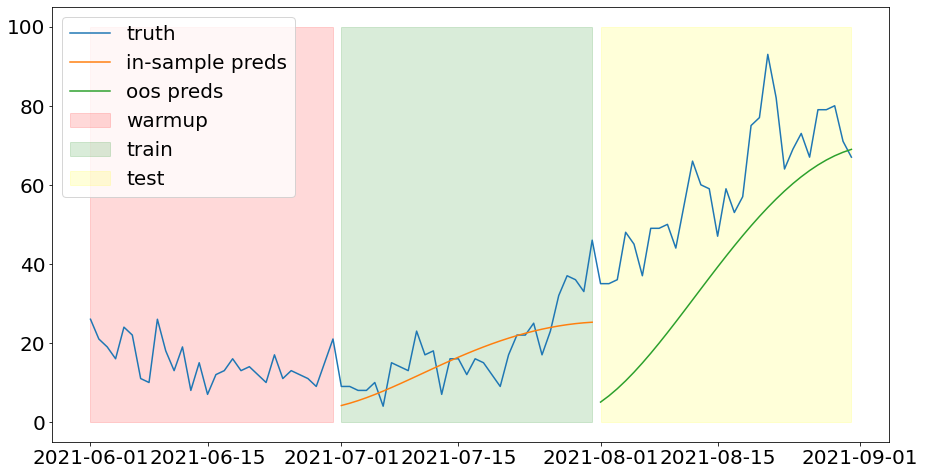

In [16]:
plt.figure(figsize=(15,8))    
plt.plot(df.loc[warmup_start:test_end].index.values,
        df.loc[warmup_start:test_end,'general_ward'].values, label = 'truth')
plt.plot(df.loc[train_start:train_end].index.values,
        preds, label = 'in-sample preds')
plt.plot(df.loc[test_start:test_end].index.values,
        test_preds, label = 'oos preds')
h1 = plt.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, 100,alpha=0.15, color='red',label='warmup')
h2 = plt.fill_between(df.loc[train_start:train_end].index.values, 0, 100,alpha=0.15, color='green', label='train')
h3 = plt.fill_between(df.loc[test_start:test_end].index.values, 0, 100,alpha=0.15, color='yellow', label='test')
plt.legend()


In [23]:
model.previously_extreme[0].stack()

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([14.205721 , 15.3890915, 16.551352 , 17.67047  , 18.718649 ,
       19.658566 , 20.43346  , 20.9436   , 20.466448 , 20.117855 ,
       19.903566 , 19.828203 , 19.894995 , 20.106493 , 20.464844 ,
       20.969835 , 21.620613 , 22.41491  , 23.348957 , 24.416483 ,
       25.610239 , 26.919239 , 28.332159 , 29.826889 , 31.383589 ,
       32.980003 , 34.58868  , 36.17975  , 37.71885  , 39.165592 ],
      dtype=float32)>

In [24]:
test_warmup_extreme[0]

array([ 8.92568308,  9.06718368,  9.24146712,  9.44915512,  9.690735  ,
        9.96624092, 10.27502781, 10.61263855, 10.98118777, 11.37959185,
       11.8056577 , 12.25885159, 12.73735869, 13.23777549, 13.75642505,
       14.29158122, 14.84119358, 15.4026385 , 15.97315282, 16.55093403,
       17.13097388, 17.71024727, 18.28819674, 18.86290265, 19.43235662,
       19.99623923, 20.55462787, 21.10388266, 21.6420796 , 22.16564178,
       22.68654268])